In [1]:
import numpy as np
import os
import cv2
from glob import glob
import matplotlib.pyplot as plt

train_img = "images/leftImg8bit/train/**/*.png"
train_annotations = "gtFine/train/**/*_gtFine_labelIds.png"
val_img = "images/leftImg8bit/val/**/*.png"
val_annotations = "gtFine/val/**/*_gtFine_labelIds.png"
test_img = "images/leftImg8bit/val/**/*.png"
test_annotations = "gtFine/test/**/*_gtFine_labelIds.png"


COLOR_MAP = { # TODO: Fix color map if needed
    (0, 0, 0): 0,       # unlabeled
    (0, 0, 1): 1,       # ego vehicle
    (0, 0, 2): 2,       # rectification border
    (0, 0, 3): 3,       # out of roi
    (0, 0, 4): 4,       # static
    (0, 0, 5): 5,
    (81, 0, 81): 6,     # ground
    (128, 64, 128): 7,  # road
    (244, 35, 232): 8,  # sidewalk
    (250, 170, 160): 9, # parking
    (230, 150, 140): 10,# rail track
    (70, 70, 70): 11,   # building
    (102, 102, 156): 12,# wall
    (190, 153, 153): 13,# fence
    (180, 165, 180): 14,# guard rail
    (150, 100, 100): 15,# bridge
    (150, 120, 90): 16, # tunnel
    (153, 153, 153): 17,# pole
    (153, 153, 153): 18,# polegroup
    (250, 170, 30): 19, # traffic light
    (220, 220, 0): 20,  # traffic sign
    (107, 142, 35): 21, # vegetation
    (152, 251, 152): 22,# terrain
    (70, 130, 180): 23, # sky
    (220, 20, 60): 24,  # person
    (255, 0, 0): 25,    # rider
    (0, 0, 142): 26,    # car
    (0, 0, 70): 27,     # truck
    (0, 60, 100): 28,   # bus
    (0, 0, 90): 29,     # caravan
    (0, 0, 110): 30,    # trailer
    (0, 80, 100): 31,   # train
    (0, 0, 230): 32,    # motorcycle
    (119, 11, 32): 33,   # bicycle
    (0, 0, 6): 34,       # static
}
IMG_HEIGHT, IMG_WIDTH = 256, 256  # Adjust as necessary
BATCH_SIZE = 8

NUM_CLASSES = len(COLOR_MAP)  # Number of classes in the dataset

def rgb_to_class_id(rgb_label):
    """Convert RGB mask to class ID mask using the color map."""
    class_id_label = np.zeros(rgb_label.shape[:2], dtype=np.int32)
    for rgb, class_id in COLOR_MAP.items():
        mask = np.all(rgb_label == rgb, axis=-1)
        class_id_label[mask] = class_id
    return class_id_label

def load_image(path, resize_shape=(IMG_HEIGHT, IMG_WIDTH)):
    img = cv2.imread(path, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, resize_shape)
    img = img / 255.0  # Normalize image
    return img

def load_mask(path, resize_shape=(IMG_HEIGHT, IMG_WIDTH)):
    color_mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    color_mask = cv2.resize(color_mask, resize_shape)
    return color_mask


train_input = np.array([load_image(img) for img in sorted(glob(train_img, recursive=True))])
train_labels = np.array([load_mask(mask) for mask in sorted(glob(train_annotations, recursive=True))])
train_input = train_input[int(len(train_input)*0.8):]
train_labels = train_labels[int(len(train_labels)*0.8):]
val_input = np.array([load_image(img) for img in sorted(glob(val_img, recursive=True))])
val_labels = np.array([load_mask(mask) for mask in sorted(glob(val_annotations, recursive=True))])
test_input = np.array([load_image(img) for img in sorted(glob(test_img, recursive=True))])
test_labels = np.array([load_mask(mask) for mask in sorted(glob(test_annotations, recursive=True))])

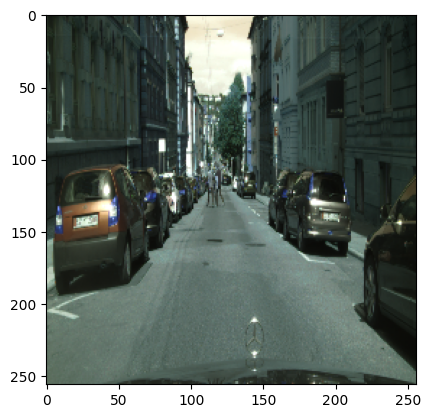

In [2]:
# Convert COLOR_MAP to a list or array for easy mapping
COLOR_MAP_LIST = np.array([rgb for rgb, class_id in sorted(COLOR_MAP.items(), key=lambda x: x[1])], dtype=np.uint8)

def class_id_to_color(class_id_mask):
    """Convert class ID mask to color-coded RGB mask."""
    # Create an empty color mask
    color_mask = np.zeros((class_id_mask.shape[0], class_id_mask.shape[1], 3), dtype=np.uint8)
    
    # Map each class ID to its corresponding color
    for class_id, color in COLOR_MAP.items():
        color_mask[class_id_mask == class_id] = color
        
    return color_mask


plt.imshow(train_input[2])

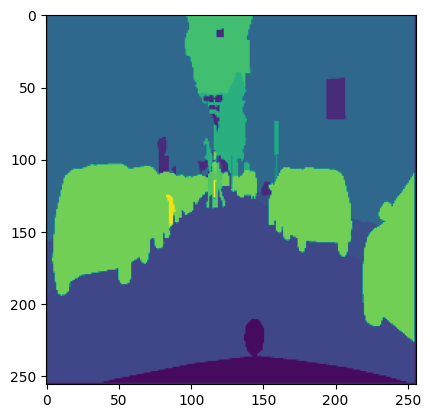

In [3]:
plt.imshow(train_labels[2])

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def unet_model(input_shape, num_classes):
    """Build U-Net model with enhancements."""
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = layers.BatchNormalization()(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = layers.BatchNormalization()(c9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create U-Net model
input_shape = (256, 256, 3)
model = unet_model(input_shape, len(COLOR_MAP))

2025-01-17 12:10:42.041944: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: FFT
2025-01-17 12:10:42.355298: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-17 12:10:43.097567: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: DNN
2025-01-17 12:10:44.863900: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-17 12:10:44.863995: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at leas

In [5]:
print(len(COLOR_MAP))

34


In [ ]:
%env GPU_DEVICE_ORDINAL="0"
%env HIP_VISIBLE_DEVICES="0"
%env ROCR_VISIBLE_DEVICES="0,svHJ.fZYPZ0y6Yz9"
import tensorflow as tf
from tensorflow.keras import backend as K

def iou_score(y_true, y_pred, smooth=1e-6):
    """Calculate the Intersection over Union (IoU)."""
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(K.abs(y_true), axis=[1,2,3]) + K.sum(K.abs(y_pred), axis=[1,2,3]) - intersection
    return K.mean((intersection + smooth) / (union + smooth), axis=0)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Calculate the Dice coefficient."""
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    return K.mean((2. * intersection + smooth) / (K.sum(K.abs(y_true), axis=[1,2,3]) + K.sum(K.abs(y_pred), axis=[1,2,3]) + smooth), axis=0)

def precision(y_true, y_pred):
    """Calculate Precision."""
    true_positive = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=[1,2,3])
    false_positive = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)), axis=[1,2,3])
    return K.mean(true_positive / (true_positive + false_positive + K.epsilon()), axis=0)

def recall(y_true, y_pred):
    """Calculate Recall."""
    true_positive = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=[1,2,3])
    false_negative = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)), axis=[1,2,3])
    return K.mean(true_positive / (true_positive + false_negative + K.epsilon()), axis=0)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=[iou_score, dice_coefficient, precision, recall])

print(len(val_input))

# Training
history = model.fit(
    train_input, train_labels,
    validation_data=(val_input, val_labels),
    batch_size=8,
    epochs=10,
    verbose=1
)

env: GPU_DEVICE_ORDINAL="0"
env: HIP_VISIBLE_DEVICES="0"
env: ROCR_VISIBLE_DEVICES="0,svHJ.fZYPZ0y6Yz9"
500
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1424s 19s/step - accuracy: 0.7724 - loss: 0.8147 - val_accuracy: 0.4168 - val_loss: 6.0495
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1424s 19s/step - accuracy: 0.7908 - loss: 0.7629 - val_accuracy: 0.5439 - val_loss: 3.1782
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1411s 19s/step - accuracy: 0.8015 - loss: 0.7196 - val_accuracy: 0.6868 - val_loss: 1.3698
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1391s 19s/step - accuracy: 0.7942 - loss: 0.7525 - val_accuracy: 0.7052 - val_loss: 1.3983
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1390s 19s/step - accuracy: 0.8098 - loss: 0.6989 - val_accuracy: 0.5954 - val_loss: 1.8707
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1394s 19s/step - accuracy: 0.8272 - loss: 0.6385 - val_accuracy: 0.7377 - val_loss: 1.2109
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1431s 19s/step - accuracy: 0.8188 - loss: 0.6607 - val_accuracy: 0.6993 - val_lo

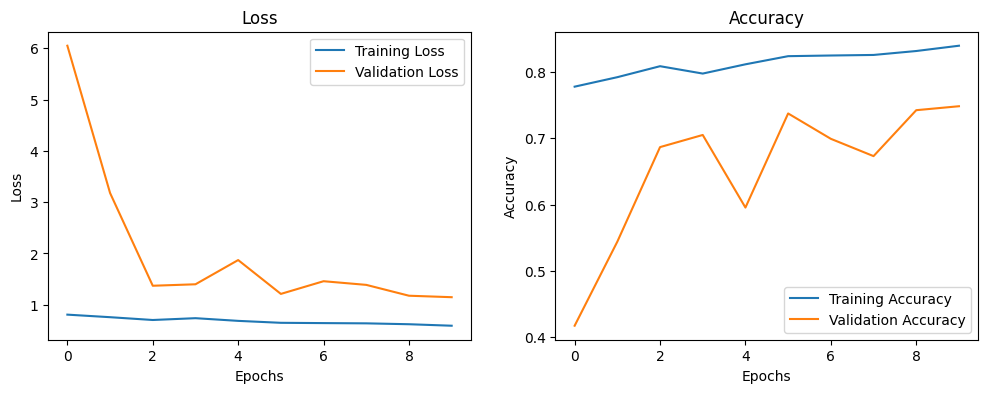

/home/ivan/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


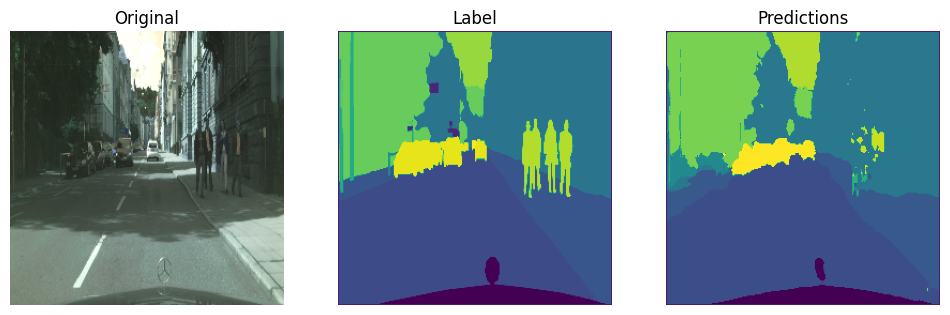

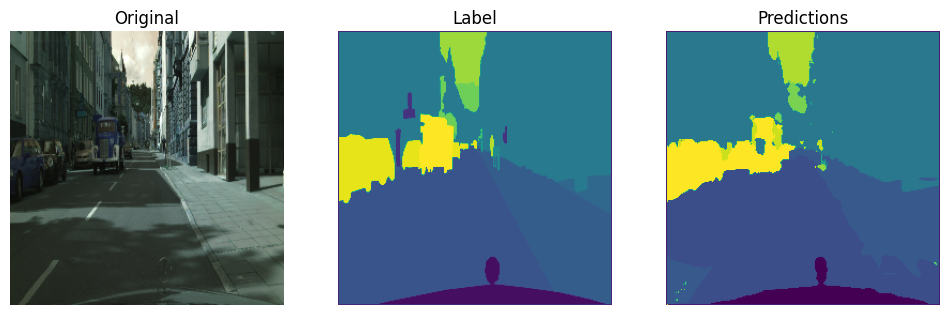

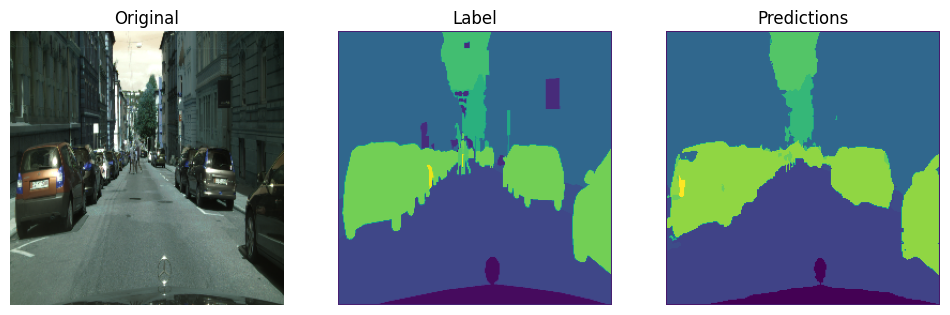

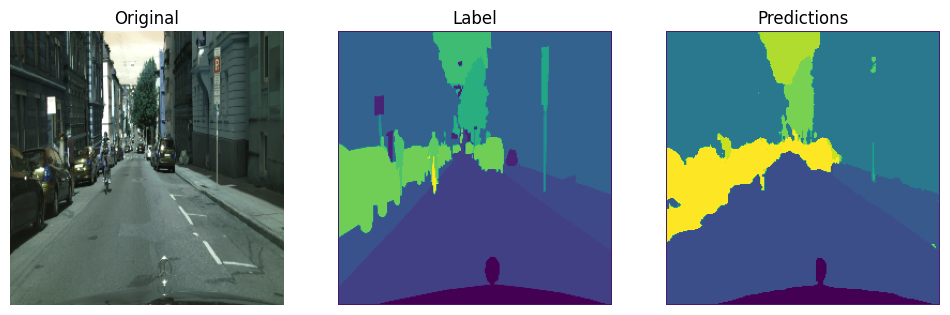

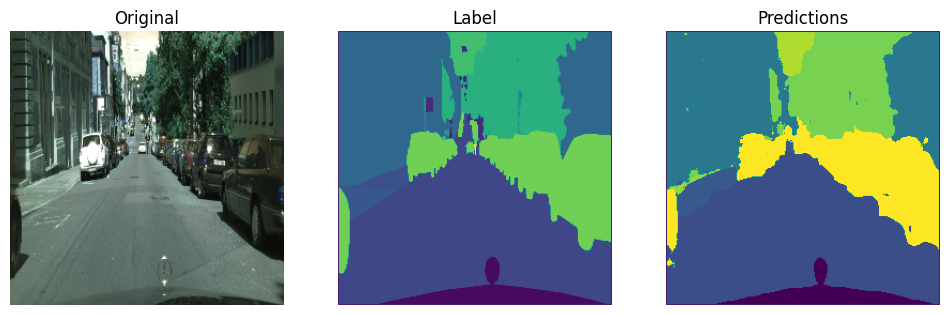

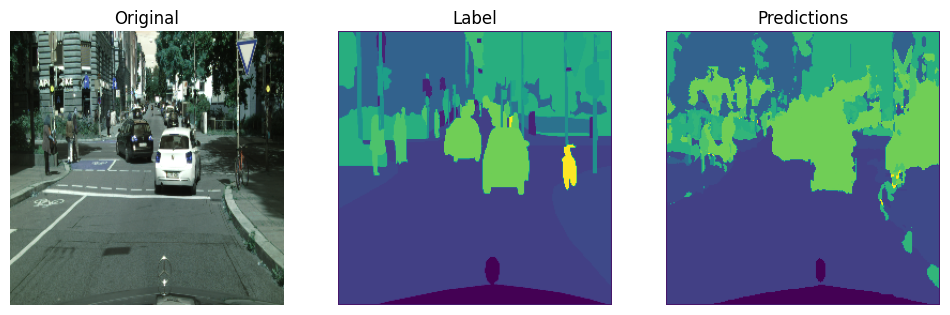

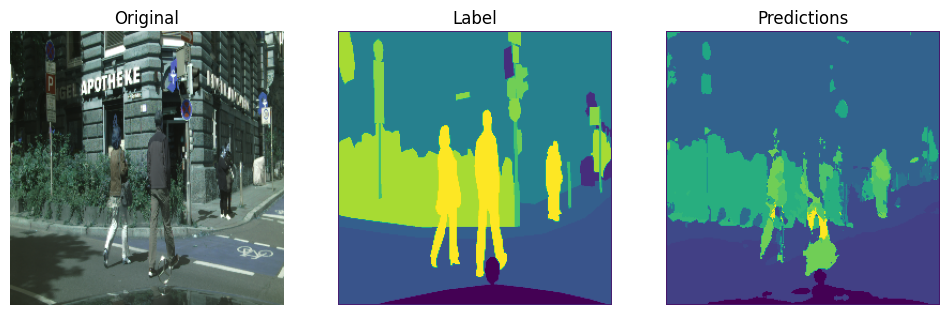

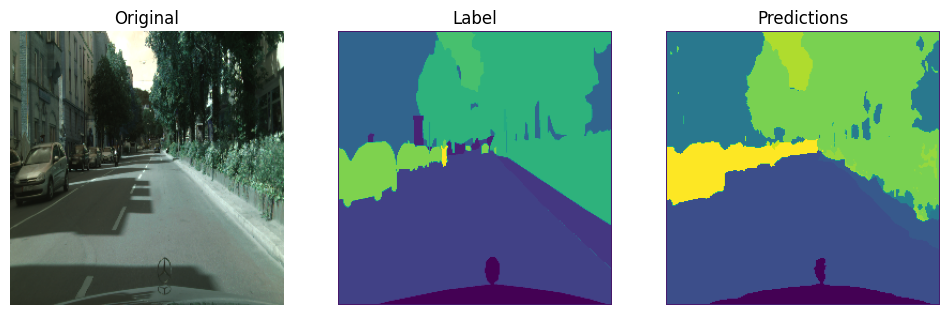

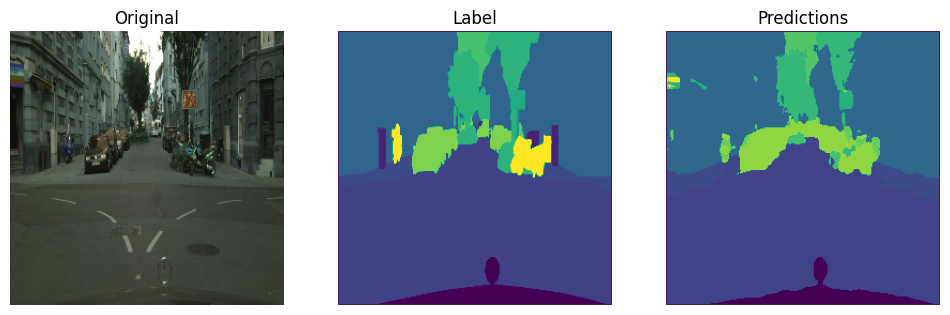

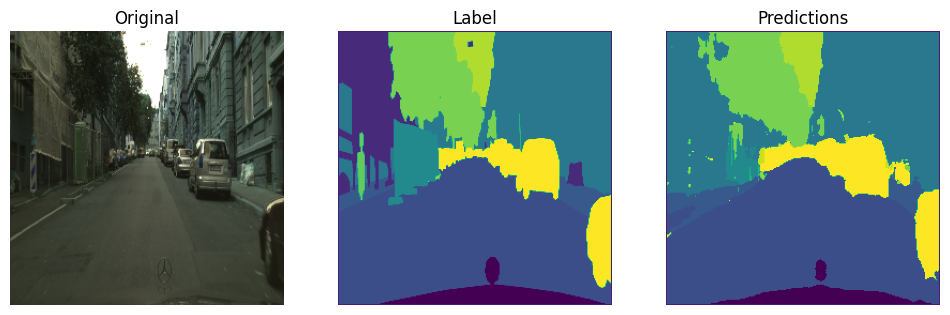

In [11]:

# Convert COLOR_MAP to a list or array for easy mapping
COLOR_MAP_LIST = np.array([rgb for rgb, class_id in sorted(COLOR_MAP.items(), key=lambda x: x[1])], dtype=np.uint8)

def class_id_to_color(class_id_mask):
    """Convert class ID mask to color-coded RGB mask."""
    # Create an empty color mask
    color_mask = np.zeros((class_id_mask.shape[0], class_id_mask.shape[1], 3), dtype=np.uint8)
    
    # Map each class ID to its corresponding color
    for class_id, color in COLOR_MAP.items():
        color_mask[class_id_mask == class_id] = color
        
    return color_mask

def plot_training_history(history):
    """Plot training and validation loss/accuracy."""
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)

def visualize_predictions(model, images, labels):
    preds = model.predict(images)
    preds = np.argmax(preds, axis=-1)
    # Visualize the first image in the 1batch and its corresponding label
    cnt = 0
    for prediction in preds:
        plt.figure(figsize=(12, 6))
        
        # Original image
        plt.subplot(1, 3, 1)
        plt.title("Original")
        plt.imshow(images[cnt])
        plt.axis('off')

        # Ground truth
        plt.subplot(1, 3, 2)
        plt.title("Label")
        plt.imshow(labels[cnt])  # Convert label to color
        plt.axis('off')

        # Model predictions
        plt.subplot(1, 3, 3)
        plt.title("Predictions")
        plt.imshow(prediction) # Show the first prediction
        plt.axis('off')
        cnt += 1

    plt.show()

# Visualize predictions
visualize_predictions(model, train_input[:10], train_labels[:10])

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def one_hot_encode(y_true, num_classes):
    """One-hot encode ground truth labels."""
    return tf.one_hot(y_true, depth=num_classes)

def iou_score(y_true, y_pred, smooth=1e-6):
    """Calculate the Intersection over Union (IoU)."""
    y_true = one_hot_encode(y_true, y_pred.shape[-1])  # One-hot encode ground truth
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(K.abs(y_true), axis=[1, 2, 3]) + K.sum(K.abs(y_pred), axis=[1, 2, 3]) - intersection
    return K.mean((intersection + smooth) / (union + smooth), axis=0)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Calculate the Dice coefficient."""
    y_true = one_hot_encode(y_true, y_pred.shape[-1])  # One-hot encode ground truth
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    return K.mean((2. * intersection + smooth) / (K.sum(K.abs(y_true), axis=[1, 2, 3]) + K.sum(K.abs(y_pred), axis=[1, 2, 3]) + smooth), axis=0)

def precision(y_true, y_pred):
    """Calculate Precision."""
    y_true = one_hot_encode(y_true, y_pred.shape[-1])  # One-hot encode ground truth
    true_positive = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=[1, 2, 3])
    false_positive = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)), axis=[1, 2, 3])
    return K.mean(true_positive / (true_positive + false_positive + K.epsilon()), axis=0)

def recall(y_true, y_pred):
    """Calculate Recall."""
    y_true = one_hot_encode(y_true, y_pred.shape[-1])  # One-hot encode ground truth
    true_positive = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=[1, 2, 3])
    false_negative = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)), axis=[1, 2, 3])
    return K.mean(true_positive / (true_positive + false_negative + K.epsilon()), axis=0)



# Assuming X_test and y_test are your test images and masks
threshold = 0.0  # Threshold to binarize predictions if using sigmoid output
ious, dices, precisions, recalls = [], [], [], []

for i in range(len(val_input)):
    img = val_input[i]
    true_mask = val_labels[i]

    # Get model prediction and binarize
    pred_mask = model.predict(img[np.newaxis, ...])[0]
    pred_mask = (pred_mask > threshold).astype(np.float32)  # Apply threshold for binary mask
    # Calculate metrics
    #ious.append(iou(true_mask, pred_mask))
    ious.append(iou_score(true_mask, pred_mask))
    dices.append(dice_coefficient(true_mask, pred_mask))
    precisions.append(precision(true_mask, pred_mask))
    recalls.append(recall(true_mask, pred_mask))
# Calculate mean metrics
mean_iou = np.max(ious)
mean_dice = np.mean(dices)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice Coefficient: {mean_dice:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


2025-01-17 18:24:18.229298: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at reduction_ops_common.h:147 : INVALID_ARGUMENT: Invalid reduction dimension (3 for input with 3 dimension(s)


InvalidArgumentError: {{function_node __wrapped__Sum_device_/job:localhost/replica:0/task:0/device:CPU:0}} Invalid reduction dimension (3 for input with 3 dimension(s) [Op:Sum]